### Preprocessing for Hu et al., 2023 (PMID: 36869384, GEO: GSE207422)

### Prerequisites

In [ ]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import os
import scvi
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

### Tidy up data

In [ ]:
from scipy.sparse import csr_matrix
counts = pd.read_csv("../yourpath/Hu2023/raw_data/all_count_clean_new.txt", header=0, index_col=0, sep="\t").T
adata = sc.AnnData(X=counts)
adata.obs['barcodes'] = counts.index
adata.var['gene_name'] = counts.columns
adata.X = csr_matrix(adata.X)
adata.obs['sample'] = adata.obs['barcodes'].str.extract(r'^(.*?_.*?)_')
bdata = adata
metadata = pd.read_excel('../yourpath/Hu2023/raw_data/GSE207422_NSCLC_scRNAseq_metadata.xlsx')
metadata = metadata.iloc[:15]
metadata['sample'] = metadata['Sample']
merged_df = bdata.obs.merge(metadata, how="left", on="sample")
bdata.obs = merged_df
bdata.obs.index = adata.obs.index
adata = bdata
adata

AnnData object with n_obs × n_vars = 92330 × 24292
    obs: 'barcodes', 'sample', 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST'
    var: 'gene_name'

In [ ]:
adata.obs['Residual Tumor'] = adata.obs['Residual Tumor'].astype(str).astype('category')
adata.write('../yourpath')

### QC

In [ ]:
###Load data
DATA_KEY = '../yourpath.h5ad'
adata = sc.read_h5ad(DATA_KEY)

###functions
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

###QC
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 10) 
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train(accelerator="cpu", devices=1)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train(accelerator="cpu", devices=1)
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df['dif'] = df.doublet - df.singlet
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
adata = sc.read_h5ad(DATA_KEY)
print(f"Total number of cells: {adata.n_obs}")
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]
print(f"Number of cells after filtering of doublets: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 200) 
adata.var['mt'] = adata.var_names.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=[20], log1p=True, inplace=True)
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
adata.obs.outlier.value_counts()
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 20)
adata.obs.mt_outlier.value_counts()
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

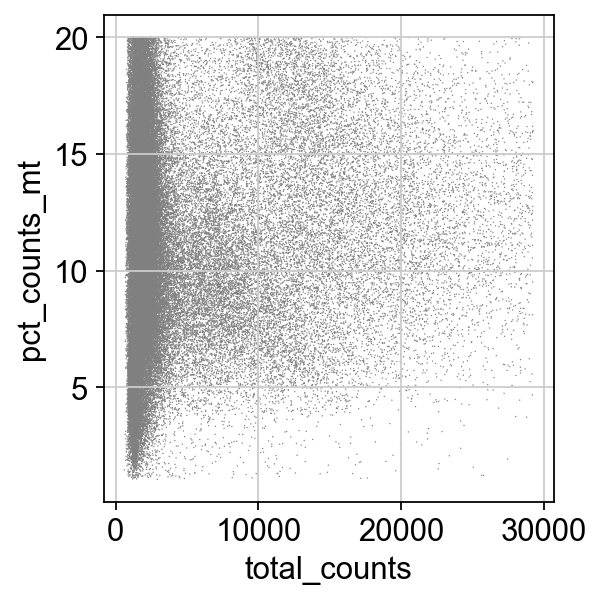

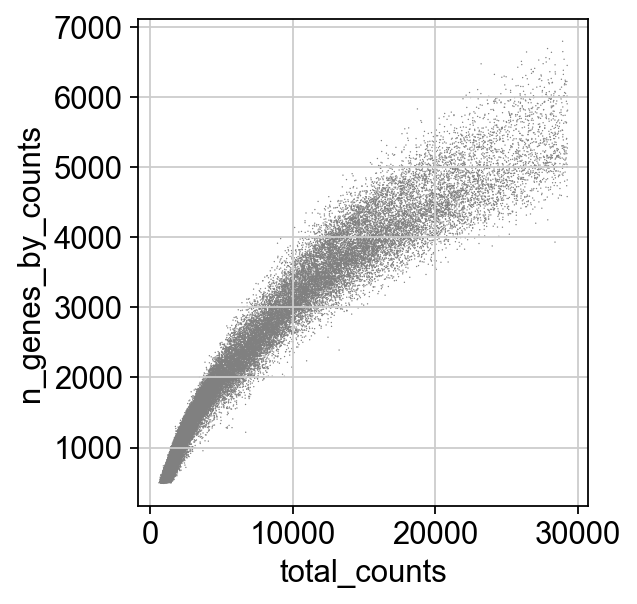

In [3]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata.write('../yourpath')

### Annotation and metadata

In [ ]:
#Load data
adata = sc.read_h5ad('../yourpath.h5ad')

#Add annotations 1
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=6000, layer="counts", subset=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

scvi.model.SCVI.setup_anndata(adata, layer='counts',
                              batch_key='sample',
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
model.train(accelerator="cpu", devices=1)
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)
adata.layers['scVI_normalized'] = model.get_normalized_expression(library_size= 1e4)

In [ ]:
#Add annotation 2
cell_type = {
    '0':'Myeloid cells',
    '1': 'T/NK cells',
    '2': 'T/NK cells',
    '3': 'T/NK cells',
    '4': 'B cells',
    '5': 'Myeloid cells',
    '6': 'Epithelial cells (malignant)',
    '7': 'Myeloid cells',
    '8': 'T/NK cells',
    '9': 'T/NK cells',
    '10': 'T/NK cells',
    '11': 'Myeloid cells',
    '12': 'Epithelial cells (malignant)',
    '13': 'T/NK cells',
    '14': 'Epithelial cells (malignant)',
    '15': 'Myeloid cells',
    '16': 'Myeloid cells',
    '17': 'B cells',
    '18': 'Fibroblasts',
    '19': 'Mast cells',
    '20': 'Epithelial cells (malignant)',
    '21': 'pDC',
    '22': 'Myeloid cells',
    '23': 'Myeloid cells',
    '24': 'B cells',
    '25': 'Endothelial cells',
}
adata.obs['anno'] = adata.obs.leiden.map(cell_type)
adata_anno = adata.obs['anno']
bdata = sc.read_h5ad(filename='../yourpath.h5ad')
bdata.obs['anno'] = adata_anno

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


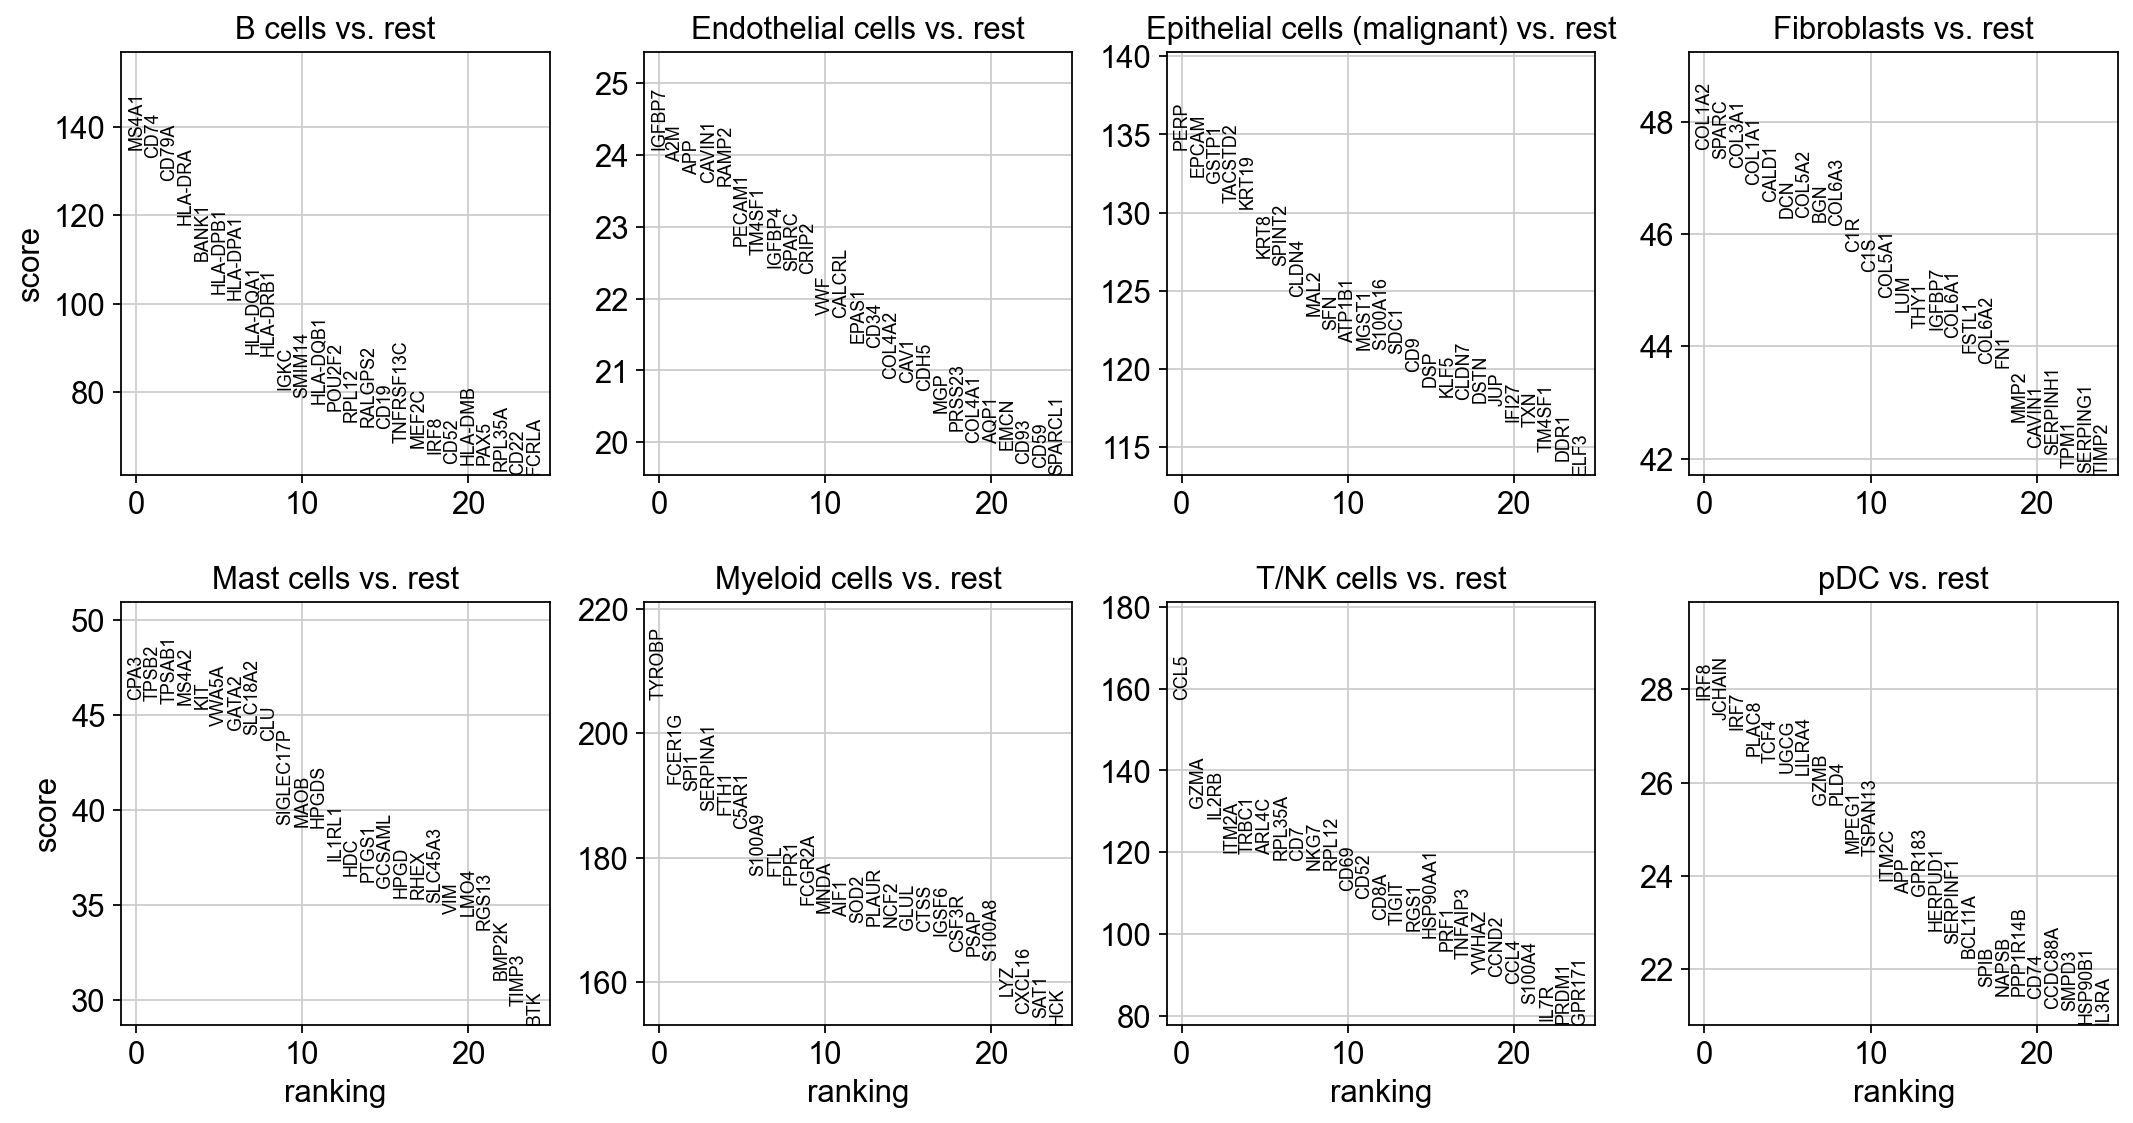

In [35]:
sc.tl.rank_genes_groups(adata, 'anno', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
bdata.obsm['X_scVI'] = adata.obsm['X_scVI']
bdata.write('../yourpath.h5ad')